## Backtest Strategy Playground

Notebook ini dipakai untuk mencoba berbagai strategy dari folder `src/strategy_backtest/strategies`.
Ganti nilai `STRATEGY_NAME` pada sel konfigurasi untuk memanggil file strategy yang berbeda.

In [1]:
from __future__ import annotations

import io
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython import get_ipython
from IPython.display import Image, display
from qf_lib.analysis.timeseries_analysis.timeseries_analysis import TimeseriesAnalysis
from qf_lib.common.enums.frequency import Frequency
from qf_lib.containers.series.simple_returns_series import SimpleReturnsSeries

PROJECT_ROOT = Path('..').resolve()
for path in (PROJECT_ROOT, PROJECT_ROOT / 'src'):
    if str(path) not in sys.path:
        sys.path.append(str(path))

_ip = get_ipython()
if _ip is not None:
    try:
        _ip.run_line_magic('matplotlib', 'inline')
    except AttributeError:
        plt.switch_backend('Agg')
else:
    plt.switch_backend('Agg')

warnings.filterwarnings('ignore', category=FutureWarning, module='qf_lib')

plt.style.use('seaborn-v0_8-darkgrid')

from src.strategy_backtest import (
    SignalBacktester,
    get_strategy,
    list_strategies,
    load_strategy_csv,
)


In [2]:
# Konfigurasi dataset & strategy
DATA_FILE = PROJECT_ROOT / 'data' / 'OKX_ETHUSDT.P, 1D.csv'
TIME_COLUMN = 'time'
PRICE_COLUMN = 'close'
ASSET_SYMBOL = 'ETHUSDT'

# Ganti nama strategy sesuai file di `src/strategy_backtest/strategies/`
STRATEGY_NAME = 'vwap'
# Opsional: override parameter default strategy
STRATEGY_PARAMS = {}

In [3]:
data, column_mapping = load_strategy_csv(DATA_FILE, time_column=TIME_COLUMN)
print(f'Dataset berisi {len(data):,} bar dengan {len(data.columns)} kolom.')
print('Contoh mapping kolom (sanitised -> original):')
for alias, original in list(column_mapping.items())[:10]:
    print(f'  {alias} -> {original}')

display(data.head())

Dataset berisi 2,152 bar dengan 35 kolom.
Contoh mapping kolom (sanitised -> original):
  time -> time
  open -> open
  high -> high
  low -> low
  close -> close
  volume -> Volume
  vwap -> VWAP
  vwap_1 -> VWAP.1
  ema -> EMA
  lucid_connector -> LUCID Connector


,open,high,low,close,volume,vwap,vwap_1,ema,lucid_connector,hyperwave,...,upper_confluence_zone,lower_confluence_zone,confluence_meter_value,custom_alert_condition_highlighter,alert_scripting_condition_highlighter,at_valuewhen,atr,histogram,macd,signal
time,,,,,,,,,,,,,,,,,,,,,
2019-12-25,127.64,127.72,123.40,125.07,2.193667e+06,125.396667,125.396667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,125.07,132.00,124.37,125.61,3.770336e+06,127.326667,127.326667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-27,125.66,126.96,122.65,126.26,5.765802e+06,125.290000,125.290000,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-28,126.24,129.68,125.86,128.09,6.235318e+06,127.876667,127.876667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-29,128.08,137.97,127.57,134.26,6.826287e+06,133.266667,133.266667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
available = list_strategies()
print('Strategi tersedia:', ', '.join(available))
strategy = get_strategy(STRATEGY_NAME, **STRATEGY_PARAMS)
print('Deskripsi strategi:')
print(f"- Nama: {strategy.metadata.name}")
print(f"- Deskripsi: {strategy.metadata.description}")
print(f"- Entry: {strategy.metadata.entry}")
print(f"- Exit: {strategy.metadata.exit}")
print('Parameter default:')
for key, value in strategy.metadata.parameters.items():
    print(f'  {key}: {value}')
if not strategy.metadata.parameters:
    print('  (tidak ada parameter default eksplisit)')
print('Parameter aktif:')
for key, value in strategy.params.items():
    print(f'  {key}: {value}')
if not strategy.params:
    print('  (menggunakan nilai default)')

signals = strategy.generate_signals(data)
print('Kolom sinyal:', list(signals.columns))
display(signals.head())

Strategi tersedia: ema112_atr, vwap
Deskripsi strategi:
- Nama: vwap
- Deskripsi: Strategi VWAP yang mencari pantulan counter-trend di bawah VWAP dan fade rally di atas VWAP saat tren turun.
- Entry: Long ketika harga pertama kali menyelam di bawah VWAP dan ada konfirmasi bullish (wick bawah, volume naik, RSI > 30) untuk potensi reversion. Short ketika harga memantul di atas VWAP dalam tren turun dengan candle rejection, volume melemah, RSI < 70 dan MACD histogram melemah.
- Exit: Keluar utama di level VWAP sebagai target reversion. Stop-loss menggunakan ATR. Jika target VWAP tercapai, posisi ditutup penuh.
Parameter default:
  rsi_window: 14
  volume_ma_window: 20
  volume_spike_ratio: 1.1
  volume_fade_ratio: 0.9
  atr_window: 14
  atr_stop_multiplier: 1.5
  min_reversion_atr: 0.5
  session_frequency: 1D
  macd_fast: 12
  macd_slow: 26
  macd_signal: 9
  wick_ratio_threshold: 0.6
  allow_counter_trend_long: True
  allow_trend_short: True
Parameter aktif:
  rsi_window: 14
  volume_ma_

,long_entry,long_exit,short_entry,short_exit,vwap,rsi,macd,macd_signal,macd_hist,atr,volume_ma,active_entry_price,stop_level,target_level,exit_flag,position
time,,,,,,,,,,,,,,,,
2019-12-25,False,False,False,False,125.396667,NaN,0.000000,0.000000,0.000000,4.320000,2.193667e+06,NaN,NaN,125.396667,<NA>,flat
2019-12-26,False,False,False,False,127.326667,NaN,0.043077,0.008615,0.034462,4.556429,2.982002e+06,NaN,NaN,127.326667,<NA>,flat
2019-12-27,False,False,False,False,125.290000,NaN,0.128188,0.032530,0.095658,4.538827,3.909935e+06,NaN,NaN,125.290000,<NA>,flat
2019-12-28,False,False,False,False,127.876667,NaN,0.339392,0.093902,0.245490,4.487482,4.491281e+06,NaN,NaN,127.876667,<NA>,flat
2019-12-29,False,False,False,False,133.266667,NaN,0.993191,0.273760,0.719431,4.909805,4.958282e+06,NaN,NaN,133.266667,<NA>,flat


In [5]:
backtester = SignalBacktester(data=data, price_column=PRICE_COLUMN)
outputs = backtester.run(signals)

metrics_series = pd.Series(outputs.metrics, name='value')
trade_summary_series = pd.Series(outputs.trade_summary, name='value')

print('Metrik performa:')
display(metrics_series.to_frame().style.format({'value': '{:.4f}'}))

print('Ringkasan trade:')
display(trade_summary_series.to_frame().style.format({'value': '{:.4f}'}))

print(f'Log trade lengkap ({len(outputs.trades)} baris):')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(outputs.trades)


Metrik performa:


,value
total_return,0.3869
cagr,0.0390
sharpe_ratio,0.4055
annualised_vol,0.1089
max_drawdown,-0.2377
avg_drawdown_duration,237.8333


Ringkasan trade:


,value
total_trades,46.0000
long_trades,31.0000
short_trades,15.0000
win_rate,0.5870
avg_pnl_pct,0.0078
median_bars,1.0000


Log trade lengkap (46 baris):


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason,entry_vwap,entry_rsi,entry_macd,entry_macd_signal,entry_macd_hist,entry_atr,entry_volume_ma,entry_active_entry_price,entry_stop_level,entry_target_level,entry_exit_flag,entry_position,exit_vwap,exit_rsi,exit_macd,exit_macd_signal,exit_macd_hist,exit_atr,exit_volume_ma,exit_active_entry_price,exit_stop_level,exit_target_level,exit_exit_flag,exit_position
0,1,Short,2020-03-21,2020-03-22,132.63,122.40,0.077132,10.23,1,short_exit_signal:target_vwap,131.970000,36.980729,-27.705815,-25.166703,-2.539112,23.096337,1.019951e+08,132.63,167.274505,131.970000,NaN,short,126.856667,34.643105,-27.306804,-25.594723,-1.712081,22.605884,1.008972e+08,132.63,167.274505,131.970000,target_vwap,short
1,2,Long,2020-04-23,2020-04-24,185.55,187.54,0.010725,1.99,1,long_exit_signal:target_vwap,185.930000,60.975038,7.167235,4.677530,2.489705,13.674277,7.232191e+07,185.55,165.038584,185.930000,NaN,long,187.333333,61.792863,7.838437,5.309711,2.528726,13.058972,7.330002e+07,185.55,165.038584,185.930000,target_vwap,long
2,3,Long,2020-05-29,2020-05-30,220.65,243.68,0.104373,23.03,1,long_exit_signal:target_vwap,221.216667,61.139673,5.062288,4.398610,0.663679,11.443060,5.218750e+07,220.65,203.485410,221.216667,NaN,long,236.720000,70.091670,7.458373,5.010562,2.447810,12.691413,5.312812e+07,220.65,203.485410,221.216667,target_vwap,long
3,4,Short,2020-06-20,2020-06-21,228.72,228.09,0.002754,0.63,1,short_exit_signal:target_vwap,228.366667,49.149919,3.033765,5.740140,-2.706376,10.624846,7.668222e+07,228.72,244.657268,228.366667,NaN,short,228.876667,48.652475,2.401917,5.072495,-2.670579,10.168785,7.166587e+07,228.72,244.657268,228.366667,target_vwap,short
4,5,Long,2020-07-26,2020-07-28,310.97,316.74,0.018555,5.77,2,long_exit_signal:target_vwap,310.990000,83.253072,15.067679,7.540103,7.527576,12.911325,1.101002e+08,310.97,291.603012,310.990000,NaN,long,316.580000,80.467428,20.112442,11.768365,8.344077,14.177469,1.399186e+08,310.97,291.603012,322.393333,target_vwap,long
5,6,Long,2020-07-29,2020-07-30,318.13,335.04,0.053154,16.91,1,long_exit_signal:target_vwap,318.773333,80.763287,21.452271,13.705146,7.747124,14.084079,1.443329e+08,318.13,297.003882,318.773333,NaN,long,330.810000,83.948600,23.606469,15.685411,7.921058,15.148787,1.529246e+08,318.13,297.003882,318.773333,target_vwap,long
6,7,Long,2020-08-04,2020-08-05,389.91,400.57,0.027340,10.66,1,long_exit_signal:target_vwap,391.463333,82.878149,37.214257,27.732719,9.481538,23.911654,2.313623e+08,389.91,354.042518,391.463333,NaN,long,397.490000,84.166987,39.065629,29.999301,9.066328,23.925108,2.392661e+08,389.91,354.042518,391.463333,target_vwap,long
7,8,Long,2020-12-17,2020-12-18,642.90,654.02,0.017297,11.12,1,long_exit_signal:target_vwap,648.380000,64.495250,25.343596,23.891991,1.451605,37.599758,2.700108e+08,642.90,586.500363,648.380000,NaN,long,649.690000,65.948574,28.207359,24.755064,3.452295,37.409061,2.716240e+08,642.90,586.500363,648.380000,target_vwap,long
8,9,Short,2021-03-05,2021-03-08,1529.32,1832.62,-0.198323,-303.30,3,short_exit_signal:stop,1506.933333,46.271162,-25.342231,4.982387,-30.324618,164.738882,5.854569e+08,1529.32,1776.428323,1506.933333,NaN,short,1780.656667,61.169558,14.333273,2.567303,11.765969,161.261725,5.995755e+08,1529.32,1776.428323,1697.230000,stop,short
9,10,Short,2021-03-21,2021-03-22,1782.33,1680.47,0.057150,101.86,1,short_exit_signal:target_vwap,1781.243333,52.941993,44.928963,48.930081,-4.001118,129.087961,5.316715e+08,1782.33,1975.961942,1781.243333,NaN,short,1713.783333,46.317959,32.955631,45.735191,-12.779561,131.070250,5.304815e+08,1782.33,1975.961942,1781.243333,target_vwap,short


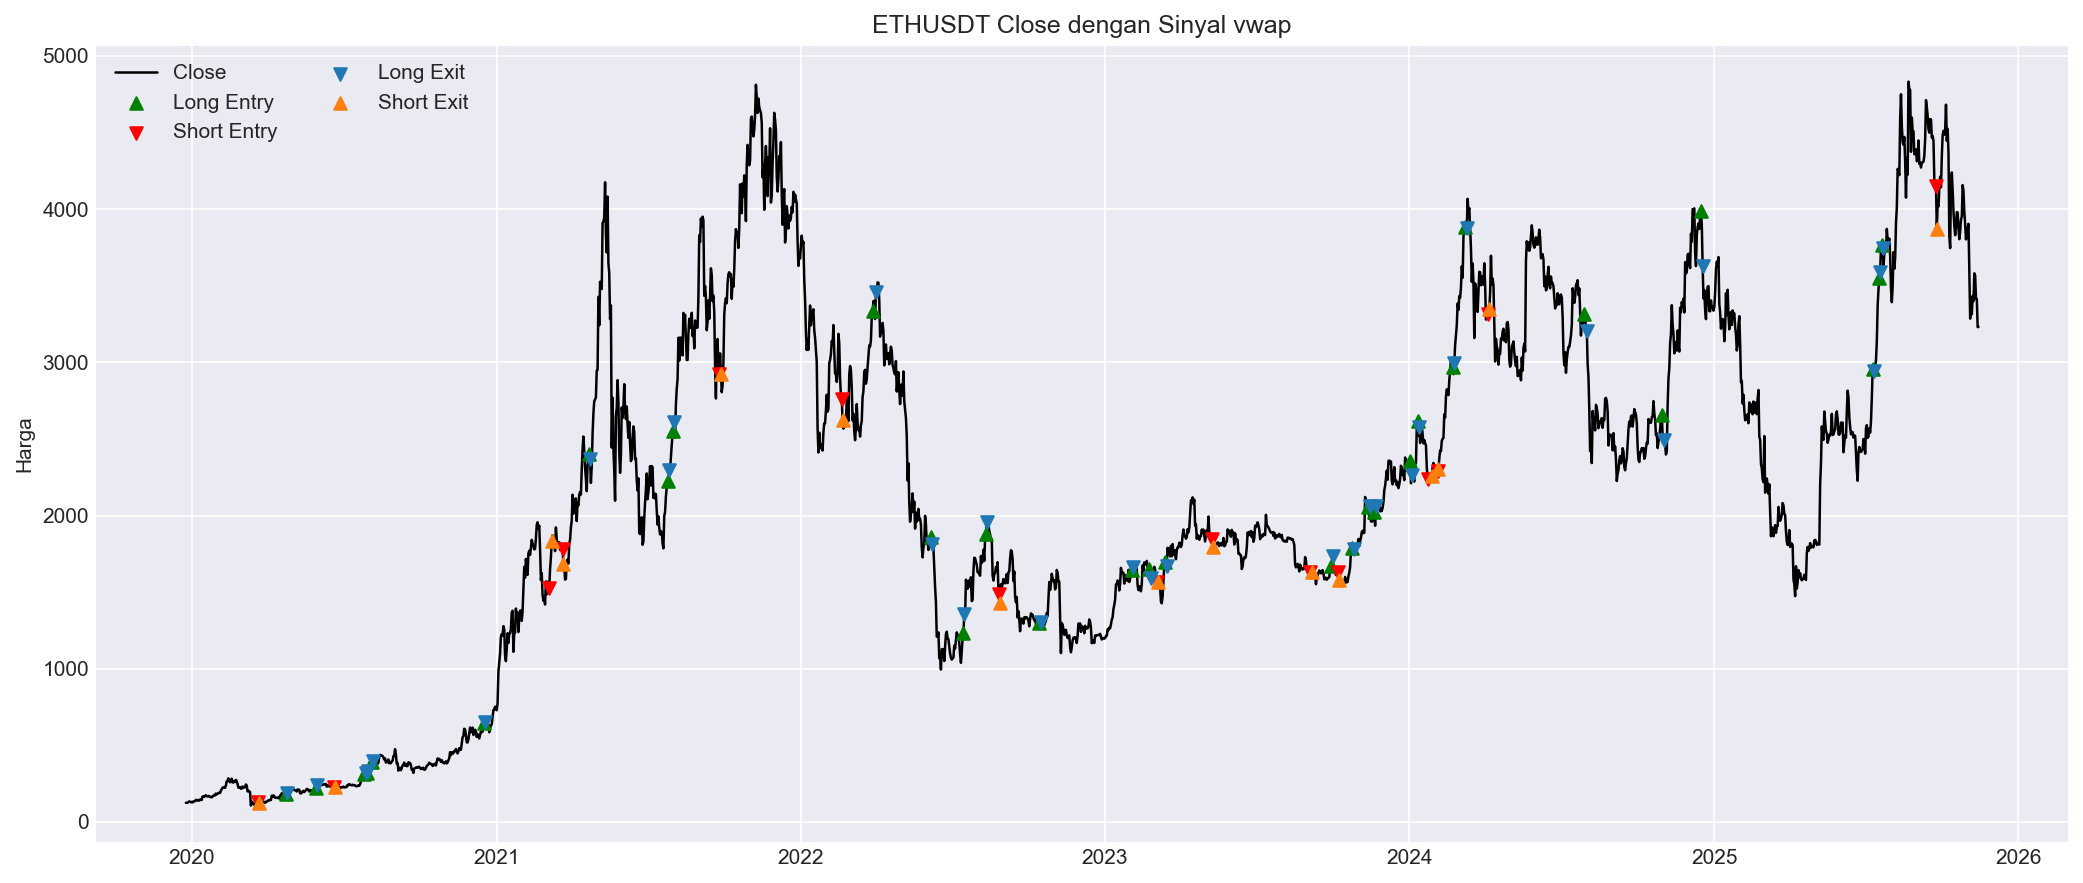

In [6]:
def _as_bool(series: pd.Series | None) -> pd.Series:
    if series is None:
        return pd.Series(False, index=data.index)
    aligned = series.reindex(data.index)
    return aligned.fillna(False).astype(bool)

close_prices = data[PRICE_COLUMN]
long_entries = _as_bool(signals.get('long_entry'))
long_exits = _as_bool(signals.get('long_exit'))
short_entries = _as_bool(signals.get('short_entry'))
short_exits = _as_bool(signals.get('short_exit'))

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(close_prices.index, close_prices, label='Close', color='black', linewidth=1.2)

if long_entries.any():
    ax.scatter(close_prices.index[long_entries], close_prices[long_entries], marker='^', color='green', label='Long Entry', zorder=5)
if short_entries.any():
    ax.scatter(close_prices.index[short_entries], close_prices[short_entries], marker='v', color='red', label='Short Entry', zorder=5)
if long_exits.any():
    ax.scatter(close_prices.index[long_exits], close_prices[long_exits], marker='v', color='tab:blue', label='Long Exit', zorder=6)
if short_exits.any():
    ax.scatter(close_prices.index[short_exits], close_prices[short_exits], marker='^', color='tab:orange', label='Short Exit', zorder=6)

ax.set_title(f'{ASSET_SYMBOL} Close dengan Sinyal {STRATEGY_NAME}')
ax.set_ylabel('Harga')
ax.legend(loc='upper left', ncol=2)
fig.tight_layout()

buffer = io.BytesIO()
fig.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
buffer.seek(0)
display(Image(data=buffer.read()))
plt.close(fig)


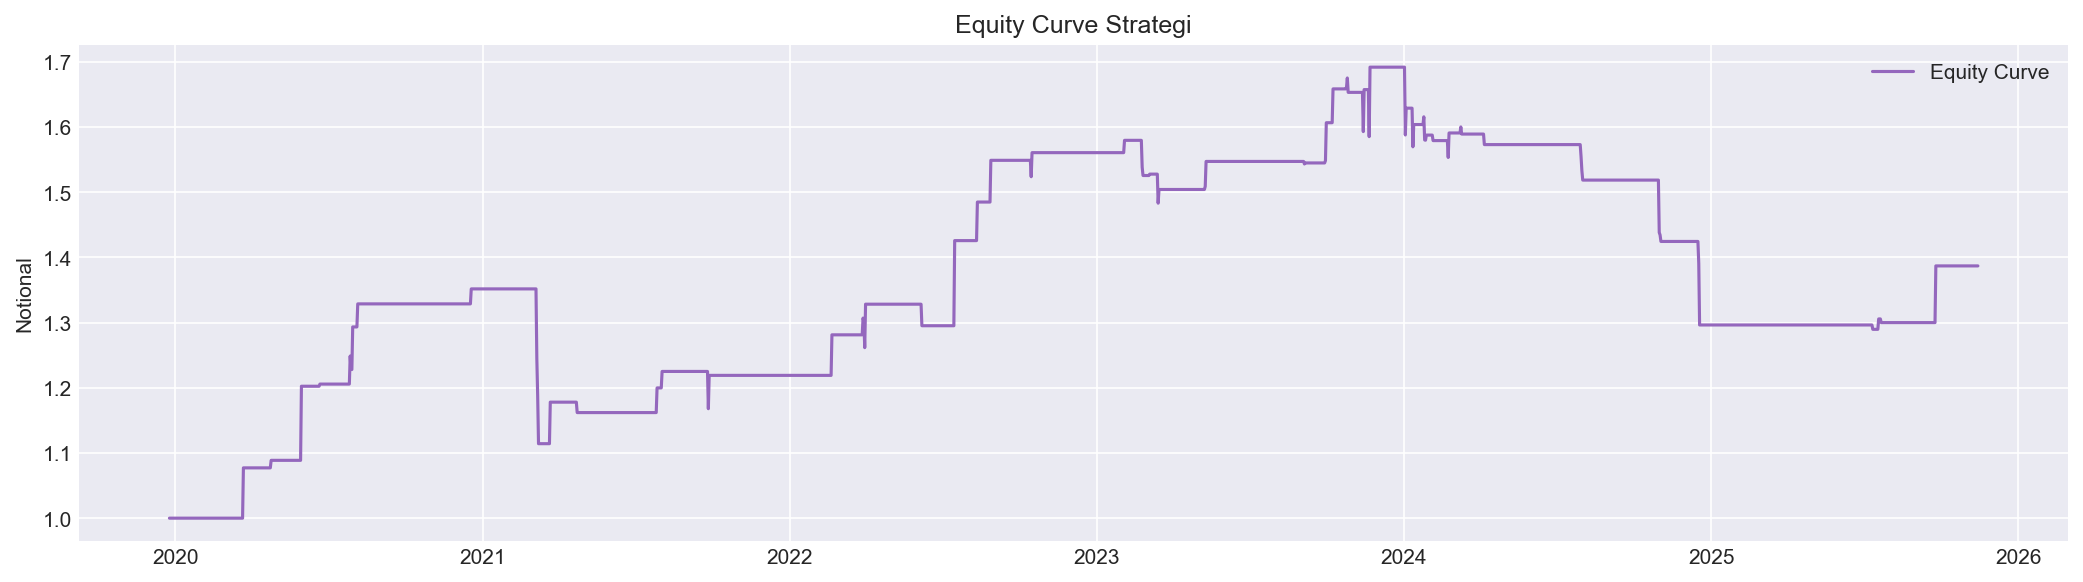

Ringkasan hasil backtest (20 bar terakhir):


,close,asset_return,position,strategy_return,equity_curve,drawdown,cumulative_pnl
time,,,,,,,
2025-10-26,4157.46,0.052053,0.0,0.0,1.386866,-0.180181,0.386866
2025-10-27,4118.31,-0.009417,0.0,-0.0,1.386866,-0.180181,0.386866
2025-10-28,3977.46,-0.034201,0.0,-0.0,1.386866,-0.180181,0.386866
2025-10-29,3900.80,-0.019274,0.0,-0.0,1.386866,-0.180181,0.386866
2025-10-30,3802.66,-0.025159,0.0,-0.0,1.386866,-0.180181,0.386866
2025-10-31,3845.80,0.011345,0.0,0.0,1.386866,-0.180181,0.386866
2025-11-01,3871.90,0.006787,0.0,0.0,1.386866,-0.180181,0.386866
2025-11-02,3904.40,0.008394,0.0,0.0,1.386866,-0.180181,0.386866
2025-11-03,3601.85,-0.077489,0.0,-0.0,1.386866,-0.180181,0.386866


Statistik return harian:


,count,mean,std,min,5%,25%,50%,75%,95%,max
series,,,,,,,,,,
asset_return,2152.0,0.002479,0.043598,-0.449160,-0.063623,-0.017922,0.001394,0.021991,0.070563,0.263237
strategy_return,2152.0,0.000175,0.006859,-0.079166,0.000000,0.000000,0.000000,0.000000,0.000000,0.104373


Return bulanan strategi:


,monthly_return
time,
2019-12-31,0.000000
2020-01-31,0.000000
2020-02-29,0.000000
2020-03-31,0.077132
2020-04-30,0.010725
...,...
2025-07-31,0.002809
2025-08-31,0.000000
2025-09-30,0.066877


In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(outputs.results.index, outputs.results['equity_curve'], color='C4', label='Equity Curve')
ax.set_title('Equity Curve Strategi')
ax.set_ylabel('Notional')
ax.legend()
fig.tight_layout()

plot_buffer = io.BytesIO()
fig.savefig(plot_buffer, format='png', dpi=150, bbox_inches='tight')
plot_buffer.seek(0)
display(Image(data=plot_buffer.read()))
plt.close(fig)

results_subset = outputs.results[['close', 'asset_return', 'position', 'strategy_return', 'equity_curve', 'drawdown', 'cumulative_pnl']]
print('Ringkasan hasil backtest (20 bar terakhir):')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_subset.tail(20))

returns_summary = outputs.results[['asset_return', 'strategy_return']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
returns_summary.index.name = 'series'
print('Statistik return harian:')
display(returns_summary)

monthly_returns = (1.0 + outputs.results['strategy_return']).resample('ME').prod() - 1.0
print('Return bulanan strategi:')
display(monthly_returns.to_frame('monthly_return'))

export_frames: dict[str, pd.DataFrame] = {
    'results_subset': results_subset,
    'returns_summary': returns_summary,
    'monthly_returns': monthly_returns.to_frame('monthly_return'),
    'full_results': outputs.results,
}
if getattr(outputs, 'trades', None) is not None:
    export_frames['trades'] = outputs.trades

export_filename = f"Optimize - {DATA_FILE.stem}.xlsx"
EXPORT_PATH = PROJECT_ROOT / 'outputs' / export_filename
EXPORT_PATH.parent.mkdir(parents=True, exist_ok=True)

with pd.ExcelWriter(EXPORT_PATH, engine='xlsxwriter') as writer:
    for sheet_name, frame in export_frames.items():
        safe_name = sheet_name[:31]
        frame.to_excel(writer, sheet_name=safe_name)

print(f'Data berhasil diekspor ke: {EXPORT_PATH}')



In [8]:
returns_series = outputs.results['strategy_return'].astype(float)
analysis = TimeseriesAnalysis(SimpleReturnsSeries(returns_series), Frequency.DAILY)

qflib_metrics = pd.Series({
    'total_return': analysis.total_return,
    'cagr': analysis.cagr,
    'sharpe_ratio': analysis.sharpe_ratio,
    'sortino_ratio': analysis.sorino_ratio,
    'omega_ratio': analysis.omega_ratio,
    'calmar_ratio': analysis.calmar_ratio,
    'gain_to_pain_ratio': analysis.gain_to_pain_ratio,
    'annualised_vol': analysis.annualised_vol,
    'annualised_downside_vol': analysis.annualised_downside_vol,
    'annualised_cvar': analysis.annualised_cvar,
    'max_drawdown': analysis.max_drawdown,
    'avg_drawdown_duration': analysis.avg_drawdown_duration,
}, name='value')

print('Metrik tambahan QF-Lib:')
display(qflib_metrics.to_frame().style.format({'value': '{:.4f}'}))

trade_distribution = outputs.trades[['pnl_pct', 'pnl_currency', 'bars_held']].describe().T
print('Statistik distribusi trade:')
display(trade_distribution)

direction_counts = outputs.trades['direction'].value_counts().rename('count').to_frame()
direction_counts['percentage'] = direction_counts['count'] / len(outputs.trades)
print('Distribusi posisi:')
display(direction_counts)

exit_reason_counts = outputs.trades['exit_reason'].value_counts().rename('count').to_frame()
exit_reason_counts['percentage'] = exit_reason_counts['count'] / len(outputs.trades)
print('Distribusi alasan keluar:')
display(exit_reason_counts)


Metrik tambahan QF-Lib:


,value
total_return,0.3869
cagr,0.0571
sharpe_ratio,0.5151
sortino_ratio,0.1639
omega_ratio,1.4404
calmar_ratio,0.2402
gain_to_pain_ratio,0.7707
annualised_vol,0.1078
annualised_downside_vol,0.3483
annualised_cvar,-0.1187


Statistik distribusi trade:


,count,mean,std,min,25%,50%,75%,max
pnl_pct,46.0,0.007833,0.048570,-0.198323,-0.00854,0.007504,0.032489,0.104373
pnl_currency,46.0,1.917609,100.135350,-358.480000,-20.17750,5.510000,50.367500,277.560000
bars_held,46.0,1.630435,0.826201,1.000000,1.00000,1.000000,2.000000,4.000000


Distribusi posisi:


,count,percentage
direction,,
Long,31,0.673913
Short,15,0.326087


Distribusi alasan keluar:


,count,percentage
exit_reason,,
long_exit_signal:target_vwap,29,0.630435
short_exit_signal:target_vwap,14,0.304348
long_exit_signal:stop,2,0.043478
short_exit_signal:stop,1,0.021739


In [9]:
def _trade_path_metrics(row: pd.Series) -> pd.Series:
    entry_time = row['entry_time']
    exit_time = row['exit_time']
    price_path = data.loc[entry_time:exit_time, PRICE_COLUMN].astype(float)
    if price_path.empty:
        return pd.Series({
            'mfe_pct': np.nan,
            'mae_pct': np.nan,
            'max_favourable_close': np.nan,
            'max_adverse_close': np.nan,
        })

    entry_price = float(row['entry_price'])
    if row['direction'] == 'Long':
        relative = price_path / entry_price - 1.0
    else:
        relative = entry_price / price_path - 1.0

    mfe_idx = relative.idxmax()
    mae_idx = relative.idxmin()
    return pd.Series({
        'mfe_pct': float(relative.max()),
        'mae_pct': float(relative.min()),
        'max_favourable_close': float(price_path.loc[mfe_idx]) if mfe_idx in price_path.index else np.nan,
        'max_adverse_close': float(price_path.loc[mae_idx]) if mae_idx in price_path.index else np.nan,
    })

loss_trades = outputs.trades.loc[outputs.trades['pnl_pct'] <= 0].copy()
if not loss_trades.empty:
    path_metrics = loss_trades.apply(_trade_path_metrics, axis=1)
    loss_trades = pd.concat([loss_trades, path_metrics], axis=1)
    loss_trades['equity_at_entry'] = outputs.results.loc[loss_trades['entry_time'], 'equity_curve'].values
    loss_trades['equity_at_exit'] = outputs.results.loc[loss_trades['exit_time'], 'equity_curve'].values
    loss_trades['drawdown_at_exit'] = outputs.results.loc[loss_trades['exit_time'], 'drawdown'].values
    loss_trades['return_vs_vwap_entry'] = loss_trades['entry_price'] / loss_trades['entry_vwap'] - 1.0
    loss_trades['return_vs_vwap_exit'] = loss_trades['exit_price'] / loss_trades['exit_vwap'] - 1.0

    columns_to_show = [
        'trade_id', 'direction', 'entry_time', 'exit_time', 'exit_reason', 'bars_held',
        'entry_price', 'exit_price', 'pnl_pct', 'mfe_pct', 'mae_pct',
        'max_favourable_close', 'max_adverse_close', 'equity_at_entry', 'equity_at_exit',
        'drawdown_at_exit', 'entry_rsi', 'exit_rsi', 'entry_macd', 'exit_macd',
        'entry_atr', 'exit_atr', 'entry_volume_ma', 'exit_volume_ma',
        'entry_stop_level', 'exit_stop_level', 'entry_target_level', 'exit_target_level',
        'return_vs_vwap_entry', 'return_vs_vwap_exit',
    ]
    available_columns = [col for col in columns_to_show if col in loss_trades.columns]
    print(f'Detail {len(loss_trades)} trade loss:')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(loss_trades[available_columns])

    loss_reason_counts = loss_trades['exit_reason'].value_counts().rename('count').to_frame()
    loss_reason_counts['percentage'] = loss_reason_counts['count'] / len(loss_trades)
    print('Ringkasan alasan trade loss:')
    display(loss_reason_counts)
else:
    print('Tidak ada trade yang mengalami kerugian pada periode ini.')


Detail 19 trade loss:


,trade_id,direction,entry_time,exit_time,exit_reason,bars_held,entry_price,exit_price,pnl_pct,mfe_pct,mae_pct,max_favourable_close,max_adverse_close,equity_at_entry,equity_at_exit,drawdown_at_exit,entry_rsi,exit_rsi,entry_macd,exit_macd,entry_atr,exit_atr,entry_volume_ma,exit_volume_ma,entry_stop_level,exit_stop_level,entry_target_level,exit_target_level,return_vs_vwap_entry,return_vs_vwap_exit
8,9,Short,2021-03-05,2021-03-08,short_exit_signal:stop,3,1529.32,1832.62,-0.198323,0.000000,-0.165501,1529.32,1832.62,1.351607,1.114229,-0.175626,46.271162,61.169558,-25.342231,14.333273,164.738882,161.261725,5.854569e+08,5.995755e+08,1776.428323,1776.428323,1506.933333,1697.230000,0.014856,0.029182
10,11,Long,2021-04-22,2021-04-23,long_exit_signal:target_vwap,1,2398.77,2366.20,-0.013578,0.000000,-0.013578,2398.77,2366.20,1.177907,1.161914,-0.140346,62.291159,60.328520,124.548243,121.787868,191.338134,201.778982,9.124695e+08,9.919984e+08,2111.762799,2111.762799,2458.163333,2458.163333,-0.024162,0.026719
13,14,Short,2021-09-25,2021-09-27,short_exit_signal:target_vwap,2,2922.22,2924.68,-0.000842,0.000000,-0.044595,2922.22,3058.62,1.225020,1.218980,-0.098125,41.283822,42.245890,-99.492203,-108.245103,269.023309,274.673312,3.193687e+09,3.050305e+09,3325.754964,3325.754964,2897.603333,2971.436667,0.008496,-0.026560
16,17,Long,2022-06-06,2022-06-07,long_exit_signal:target_vwap,1,1859.69,1813.43,-0.024875,0.000000,-0.024875,1859.69,1813.43,1.328153,1.295115,-0.041796,41.923544,39.926134,-137.320077,-130.900831,131.873643,133.631954,4.088946e+09,4.209705e+09,1661.879535,1661.879535,1862.280000,1862.280000,-0.001391,0.004778
22,23,Long,2023-02-23,2023-02-25,long_exit_signal:target_vwap,2,1650.75,1594.36,-0.034160,0.000000,-0.034160,1650.75,1594.36,1.579458,1.525503,-0.034160,54.653424,48.125306,30.867053,20.162464,74.137153,73.727596,4.502530e+09,4.572033e+09,1539.544270,1539.544270,1652.626667,1615.133333,-0.001136,0.004883
24,25,Long,2023-03-14,2023-03-16,long_exit_signal:target_vwap,2,1699.51,1673.30,-0.015422,0.000000,-0.029173,1699.51,1649.93,1.527635,1.504076,-0.047726,61.082136,57.626746,-3.369046,8.671414,82.660270,82.771151,5.007238e+09,5.041072e+09,1575.519595,1575.519595,1711.836667,1659.736667,-0.007201,0.004111
26,27,Short,2023-09-04,2023-09-06,short_exit_signal:target_vwap,2,1630.65,1633.08,-0.001490,0.000000,-0.002526,1630.65,1634.78,1.547095,1.544782,-0.021954,36.077585,36.803677,-42.157077,-39.843157,49.680582,50.100910,2.778102e+09,2.435285e+09,1705.170872,1705.170872,1630.586667,1630.946667,0.000039,-0.003166
29,30,Long,2023-10-24,2023-10-27,long_exit_signal:target_vwap,3,1785.32,1779.58,-0.003215,0.010088,-0.003215,1803.33,1779.58,1.658353,1.653022,-0.013170,72.860980,69.040594,21.329450,43.006406,58.381782,62.246507,2.909671e+09,3.250945e+09,1697.747327,1697.747327,1798.773333,1811.736667,-0.007479,0.002650
32,33,Long,2024-01-02,2024-01-04,long_exit_signal:target_vwap,2,2355.39,2267.84,-0.037170,0.000000,-0.061485,2355.39,2210.57,1.691673,1.628794,-0.037170,58.973851,50.785561,41.279922,26.567044,96.799576,112.389991,4.616381e+09,4.688950e+09,2210.190636,2210.190636,2375.040000,2216.406667,-0.008274,0.005569
33,34,Long,2024-01-11,2024-01-13,long_exit_signal:target_vwap,2,2618.07,2577.68,-0.015427,0.000000,-0.036401,2618.07,2522.77,1.628794,1.603666,-0.052024,70.699411,65.091239,61.863239,77.893648,125.856003,132.423339,5.025064e+09,5.411525e+09,2429.285996,2429.285996,2624.853333,2566.180000,-0.002584,0.008860


Ringkasan alasan trade loss:


,count,percentage
exit_reason,,
long_exit_signal:target_vwap,11,0.578947
short_exit_signal:target_vwap,5,0.263158
long_exit_signal:stop,2,0.105263
short_exit_signal:stop,1,0.052632
